![image.png](https://i.imgur.com/a3uAqnb.png)

# 🎛️ Tajweed Audio Classification with EfficientNet-B0
## Deep Learning for Quranic Recitation Analysis

This comprehensive notebook demonstrates the power of **Convolutional Neural Networks (CNNs)** for audio classification tasks using mel spectrograms. We'll explore how to process audio data, convert it to visual representations, and train a state-of-the-art vision model for audio classification.

### **📌 What We'll Cover:**

1. **Audio Processing Pipeline**: Converting raw audio to mel spectrograms for CNN input
2. **EfficientNet-B0 Architecture**: Using a pretrained vision model for audio classification
3. **Cross-Validation Training**: Robust model evaluation with 5-fold stratified CV
4. **Overfitting Analysis**: Understanding model performance and generalization
5. **Feature Engineering**: Log-mel spectrograms as "images" for CNN processing

### **🎯 Our Dataset: Tajweed Rules Classification**
We'll use a dataset that classifies different Tajweed rules in Quranic recitation. This is a specialized audio classification task where we need to identify pronunciation rules based on audio features.

### **🔊 Audio-to-Vision Transfer Learning**
Our approach converts audio signals into visual spectrograms, allowing us to leverage powerful vision models like EfficientNet for audio classification tasks. This technique has proven highly effective across many audio domains.

In [1]:
from IPython.display import clear_output
# run this if you are working on colab(disgusting 🤮)
!pip install torchmetrics

clear_output()

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mohammad2012191/tajweed-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/


In [3]:
## 🎛️ Configuration & Imports

import random, os, gc
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import torch.nn as nn, torch.nn.functional as F
import torchaudio

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold
from torchmetrics.classification import F1Score
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import time


# reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# audio parameters
SAMPLE_RATE = 16_000       # Hz
MAX_SEC     = 4.0          # seconds
MAX_LEN     = int(SAMPLE_RATE * MAX_SEC)  # samples

# training parameters
BATCH   = 32
EPOCHS  = 5
LR      = 3e-4
K_FOLDS = 5

# I/O paths
WORK_DIR  = Path(path)
TRAIN_CSV = WORK_DIR/"train.csv"
TRAIN_DIR = WORK_DIR/"train"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)


Using device: cuda


## 🔍 Exploratory Data Analysis (EDA)

Before diving into model training, we need to understand our dataset structure and characteristics. This section will help us:

### **🎵 Key Analysis Steps:**
1. **Dataset Overview**: Understanding file structure, sample counts, and label distribution
2. **Reciter Analysis**: Examining which reciters are included and their representation
3. **Label Distribution**: Checking class balance for our 4 Tajweed rules
4. **Data Quality Assessment**: Ensuring our training data is well-distributed

### **📊 Why EDA Matters for Audio:**
- **Class Imbalance**: Audio datasets often have uneven class distributions
- **Speaker Diversity**: Different reciters may have varying styles and audio quality
- **Feature Understanding**: Knowing our target classes helps in model interpretation

### **🎨 Visualization Strategy:**
We'll create visualizations to understand:
- Reciter distribution across the dataset
- Tajweed rule frequency and balance
- Overall dataset characteristics that might affect training

📊 Dataset Overview:
   Total samples: 1,515
   Number of classes: 4
   Classes: ['Idgham', 'Ikhfa', 'Iqlab', 'Izhar']
   Number of reciters: 8


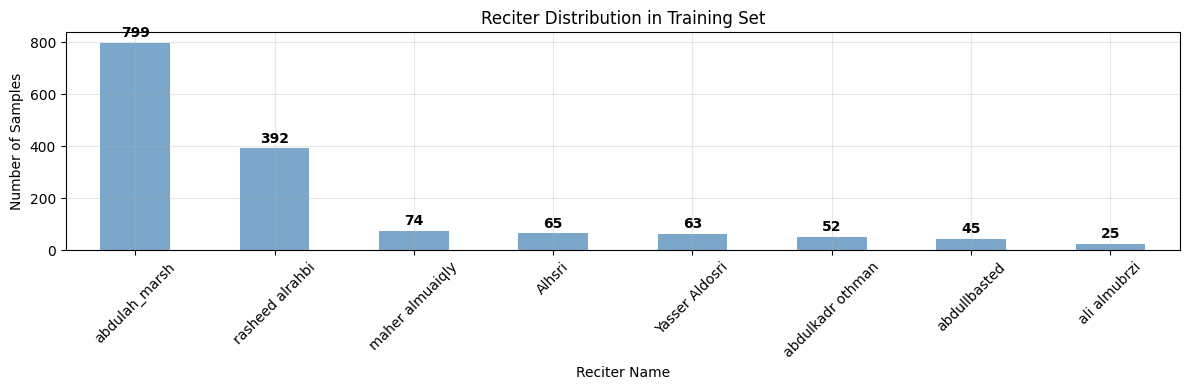


🏷️ Tajweed Rule Distribution:
   Idgham         :  527 samples ( 34.8%)
   Izhar          :  429 samples ( 28.3%)
   Ikhfa          :  404 samples ( 26.7%)
   Iqlab          :  155 samples ( 10.2%)

⚖️ Class Balance Analysis:
   Imbalance ratio: 3.40:1
   ⚠️ Significant class imbalance detected - consider stratified sampling


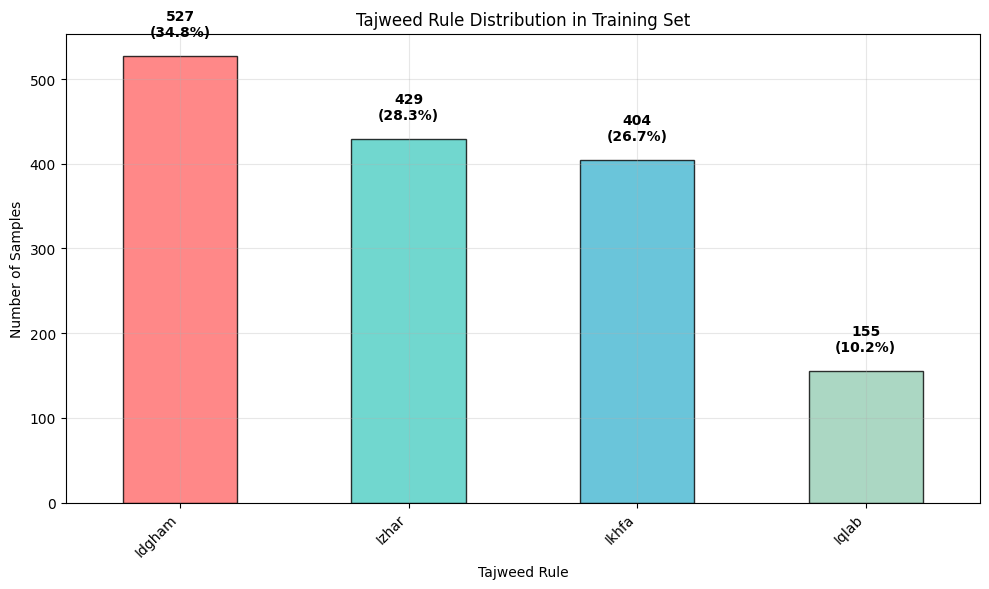

In [4]:
# 🔍 Load and explore the Tajweed dataset
train_df = pd.read_csv(TRAIN_CSV)

# Create label encodings for model training
# LabelEncoder converts string labels to integers (required for PyTorch)
le = LabelEncoder().fit(train_df["label_name"])
train_df["y"] = le.transform(train_df["label_name"])

print(f"📊 Dataset Overview:")
print(f"   Total samples: {len(train_df):,}")
print(f"   Number of classes: {len(le.classes_)}")
print(f"   Classes: {list(le.classes_)}")
print(f"   Number of reciters: {train_df.sheikh_name.nunique()}")

# Visualize reciter distribution - important for understanding data bias
fig, axes = plt.subplots(1,1, figsize=(12,4), sharey=True)
reciter_counts = train_df.sheikh_name.value_counts()
reciter_counts.plot.bar(ax=axes, title="Reciter Distribution in Training Set",
                       color='steelblue', alpha=0.7)
axes.set_xlabel("Reciter Name")
axes.set_ylabel("Number of Samples")
axes.tick_params(axis='x', rotation=45)
axes.grid(True, alpha=0.3)

# Add count labels on bars for better readability
for i, (reciter, count) in enumerate(reciter_counts.items()):
    axes.text(i, count + 10, str(count), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Analyze label distribution - crucial for understanding class balance
print(f"\n🏷️ Tajweed Rule Distribution:")
label_counts = train_df.label_name.value_counts()
for rule, count in label_counts.items():
    percentage = (count / len(train_df)) * 100
    print(f"   {rule:<15}: {count:4d} samples ({percentage:5.1f}%)")

# Check for class imbalance
imbalance_ratio = label_counts.max() / label_counts.min()
print(f"\n⚖️ Class Balance Analysis:")
print(f"   Imbalance ratio: {imbalance_ratio:.2f}:1")
if imbalance_ratio > 3:
    print("   ⚠️ Significant class imbalance detected - consider stratified sampling")
else:
    print("   ✅ Reasonable class balance")

# Label histogram with enhanced styling
plt.figure(figsize=(10,6))
bars = label_counts.plot.bar(title="Tajweed Rule Distribution in Training Set",
                            color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'],
                            alpha=0.8, edgecolor='black', linewidth=1)
plt.xlabel("Tajweed Rule")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)

# Add value labels and percentages on bars
for i, (rule, count) in enumerate(label_counts.items()):
    percentage = (count / len(train_df)) * 100
    plt.text(i, count + 20, f'{count}\n({percentage:.1f}%)',
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## 🎶 Audio Processing Pipeline: From Sound to Spectrograms

This is where the magic happens! We'll convert raw audio files into **mel spectrograms** - visual representations that capture the essential frequency information in audio signals.

### **🔊 Understanding Mel Spectrograms:**

**What is a Mel Spectrogram?**
- **Time-Frequency Representation**: Shows how frequency content changes over time
- **Mel Scale**: Perceptually-motivated frequency scale that mimics human hearing
- **Visual Format**: Converts 1D audio → 2D image that CNNs can process

### **🛠️ Our Processing Pipeline:**

1. **Audio Loading**: Load WAV files and resample to consistent 16kHz
2. **Mono Conversion**: Convert stereo to mono for consistency
3. **Mel Transform**: Apply mel spectrogram with 128 mel bins
4. **Log Scaling**: Apply logarithmic scaling for better dynamic range
5. **Normalization**: Standardize values for stable training
6. **Padding/Trimming**: Fixed-length sequences for batch processing
7. **Channel Replication**: Convert 1-channel spectrogram to 3-channel "RGB" image

### **⚙️ Key Parameters:**
- **Sample Rate**: 16kHz (standard for speech/audio ML)
- **Max Duration**: 4 seconds (captures typical Tajweed phrase length)
- **Mel Bins**: 128 (good balance between detail and computational efficiency)
- **FFT Settings**: 1024 FFT size, 512 hop length for good time-frequency resolution

### **🎯 Why This Approach Works:**
- **Transfer Learning**: Pretrained vision models can process spectrogram "images"
- **Rich Representation**: Mel spectrograms capture both temporal and spectral patterns
- **Proven Success**: This technique has achieved SOTA results in many audio tasks

In [5]:
class TajweedSpecDataset(Dataset):
    """
    Custom PyTorch Dataset for Tajweed audio classification.

    Converts audio files to log-mel spectrograms suitable for CNN training.
    Each audio file is processed into a 3-channel 'image' that EfficientNet can handle.
    """

    def __init__(self, df, folder, return_id=False):
        """
        Initialize the dataset.

        Args:
            df: DataFrame with audio file IDs and labels
            folder: Path to folder containing audio files
            return_id: If True, return file ID instead of label (for inference)
        """
        self.df = df.reset_index(drop=True)
        self.folder = Path(folder)
        self.return_id = return_id

        # Create mel spectrogram transform
        # These parameters are carefully chosen for good time-frequency resolution
        self.mel = torchaudio.transforms.MelSpectrogram(
            sample_rate=SAMPLE_RATE,    # 16kHz - standard for speech
            n_fft=1024,                 # FFT window size - good frequency resolution
            hop_length=512,             # Step size - 50% overlap for smooth transitions
            n_mels=128                  # Number of mel bins - captures human hearing range
        )

        print(f"   🎵 Dataset initialized with {len(self.df)} samples")
        print(f"   📁 Audio folder: {self.folder}")
        print(f"   🔧 Mel spectrogram: {SAMPLE_RATE}Hz, {1024}FFT, {128}mel bins")

    def _pad_trim(self, spec):
        """
        Ensure all spectrograms have the same time dimension.

        Fixed-length sequences are essential for batch training.
        We pad short sequences and trim long ones to MAX_LEN.
        """
        # Calculate target time dimension based on hop length
        T = MAX_LEN // 512  # 512 is hop_length

        if spec.size(-1) < T:
            # Pad short sequences with zeros
            return F.pad(spec, (0, T - spec.size(-1)))

        # Trim long sequences
        return spec[..., :T]

    def __getitem__(self, idx):
        """
        Load and process a single audio sample.

        Returns:
            img: 3-channel mel spectrogram "image" [3, 128, T]
            target: Either label (int) or file ID (str)
        """
        row = self.df.iloc[idx]

        # Load audio file
        path = self.folder / f"{row['id']}.wav"
        try:
            wav, sr = torchaudio.load(str(path))
        except Exception as e:
            print(f"⚠️ Error loading {path}: {e}")
            # Return a zero tensor if file can't be loaded
            wav = torch.zeros((1, MAX_LEN))
            sr = SAMPLE_RATE

        # Resample if necessary (ensure consistent sample rate)
        if sr != SAMPLE_RATE:
            wav = torchaudio.functional.resample(wav, sr, SAMPLE_RATE)

        # Convert to mono by averaging channels
        # Shape: [channels, time] → [1, time]
        wav = wav.mean(0, keepdim=True)

        # Apply mel spectrogram transform
        # Shape: [1, time] → [1, mel_bins, time_frames]
        spec = self.mel(wav)

        # Apply log scaling for better dynamic range
        # Log scaling compresses large values and expands small ones
        spec = 10 * torch.log10(spec + 1e-6)  # Add epsilon to avoid log(0)

        # Ensure fixed time dimension for batch processing
        spec = self._pad_trim(spec)

        # Normalize to zero mean, unit variance for stable training
        # Each sample is independently normalized
        spec = (spec - spec.mean()) / (spec.std() + 1e-6)

        # Convert to 3-channel "RGB" image for EfficientNet
        # EfficientNet expects 3-channel input, so we replicate the mel spectrogram
        img = spec.repeat(3, 1, 1)  # [1, 128, T] → [3, 128, T]

        # Return appropriate target based on mode
        if self.return_id:
            return img, row["id"]  # For inference/testing
        else:
            return img, torch.tensor(row["y"], dtype=torch.long)  # For training

    def __len__(self):
        """Return the total number of samples in the dataset."""
        return len(self.df)

## 🔊 Visualizing Audio as Images: Sample Spectrograms

Now let's see what our audio data looks like when converted to visual spectrograms! This visualization helps us understand:

### **📊 Interpretation Guide:**
- **Vertical Axis**: Frequency (mel bins) - lower frequencies at bottom, higher at top
- **Horizontal Axis**: Time - how the sound evolves from left to right  
- **Color Intensity**: Magnitude - brighter areas indicate stronger frequency components
- **Patterns**: Each Tajweed rule should have characteristic visual "fingerprints"

🔍 Generating sample spectrograms for visual inspection...
   🎵 Dataset initialized with 4 samples
   📁 Audio folder: /kaggle/input/train
   🔧 Mel spectrogram: 16000Hz, 1024FFT, 128mel bins
📊 Sample Details:
   Sample 1: Ikhfa (Reciter: abdulah_marsh)
   Sample 2: Idgham (Reciter: rasheed alrahbi)
   Sample 3: Iqlab (Reciter: abdulah_marsh)
   Sample 4: Izhar (Reciter: abdulah_marsh)


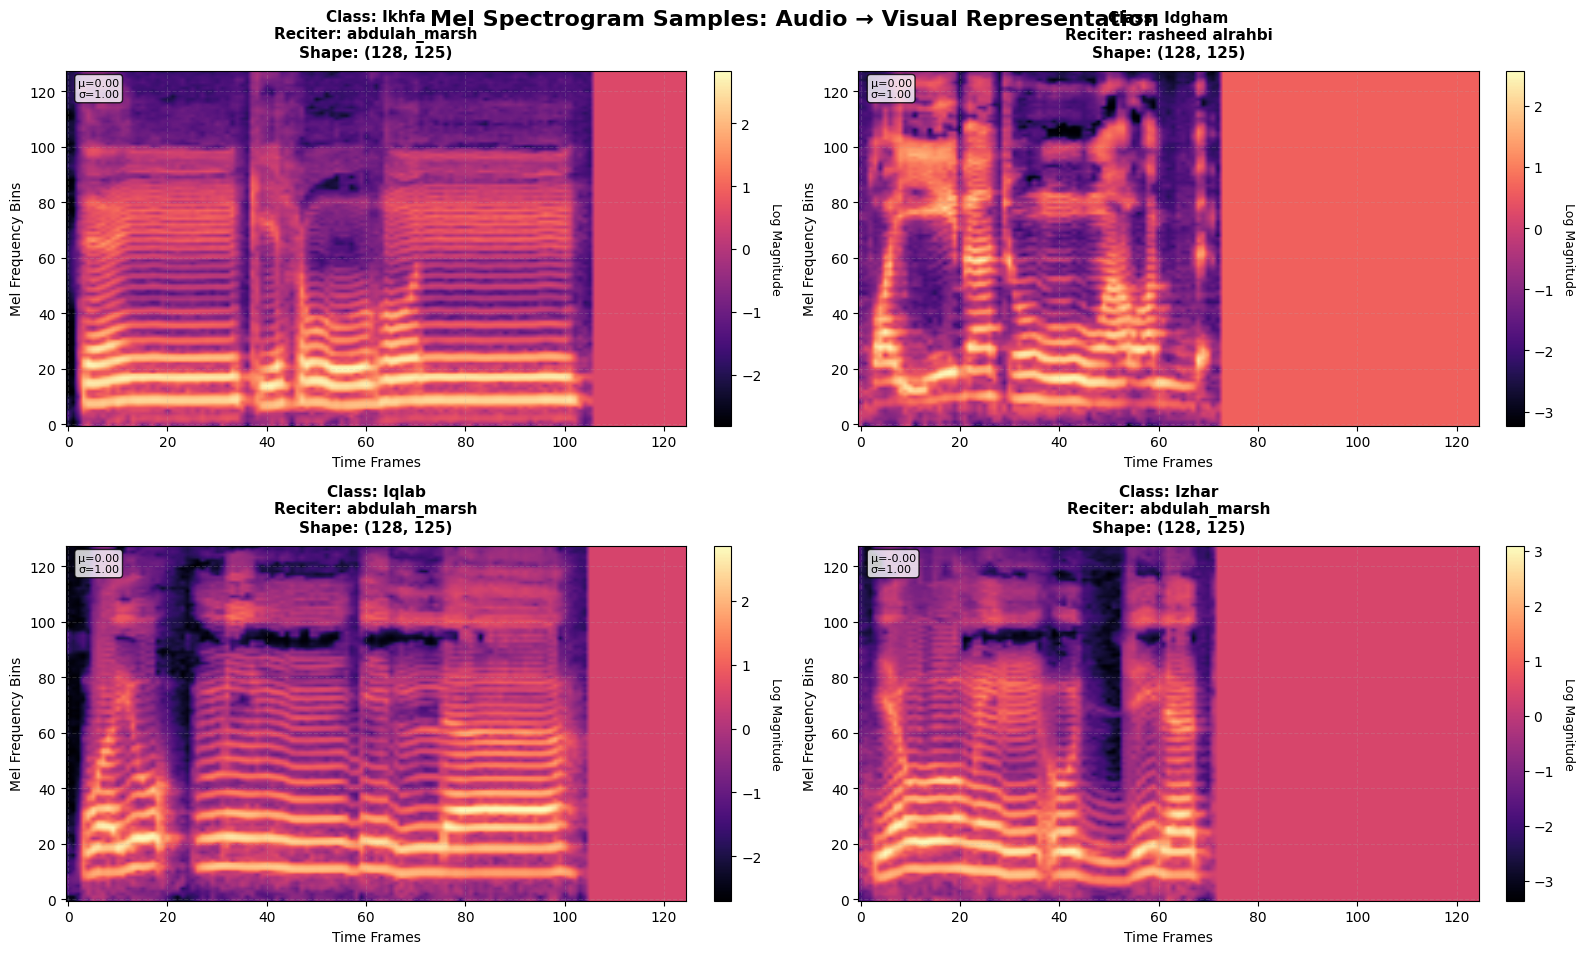

In [6]:
# 🎨 Visualize sample mel spectrograms to understand our data
print("🔍 Generating sample spectrograms for visual inspection...")

# Select diverse samples - one from each class if possible
sample_indices = []
for class_name in train_df['label_name'].unique()[:4]:
    class_samples = train_df[train_df['label_name'] == class_name]
    if len(class_samples) > 0:
        sample_indices.append(class_samples.sample(1, random_state=SEED).index[0])

# If we don't have 4 classes, fill with random samples
while len(sample_indices) < 4:
    remaining = train_df.index.difference(sample_indices)
    sample_indices.append(np.random.choice(remaining))

sample = train_df.iloc[sample_indices]
ds = TajweedSpecDataset(sample, TRAIN_DIR, return_id=False)

print(f"📊 Sample Details:")
for i, (idx, row) in enumerate(sample.iterrows()):
    print(f"   Sample {i+1}: {row['label_name']} (Reciter: {row['sheikh_name']})")

# Create enhanced visualization
plt.figure(figsize=(16, 10))

for i, (img, lbl) in enumerate(ds):
    # Use the first channel of our 3-channel image
    spectrogram = img[0].numpy()
    sample_info = sample.iloc[i]

    plt.subplot(2, 2, i+1)

    # Create the spectrogram plot with custom colormap
    im = plt.imshow(spectrogram, aspect='auto', origin='lower',
                   cmap='magma', interpolation='bilinear')

    # Enhanced title with multiple pieces of information
    plt.title(f'Class: {sample_info["label_name"]}\n'
             f'Reciter: {sample_info["sheikh_name"]}\n'
             f'Shape: {spectrogram.shape}',
             fontsize=11, fontweight='bold', pad=10)

    # Add axis labels and formatting
    plt.xlabel('Time Frames', fontsize=10)
    plt.ylabel('Mel Frequency Bins', fontsize=10)

    # Add colorbar for this subplot
    cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
    cbar.set_label('Log Magnitude', rotation=270, labelpad=15, fontsize=9)

    # Add grid for better readability
    plt.grid(True, alpha=0.2, linestyle='--')

    # Add some statistics as text
    mean_val = spectrogram.mean()
    std_val = spectrogram.std()
    plt.text(0.02, 0.98, f'μ={mean_val:.2f}\nσ={std_val:.2f}',
             transform=plt.gca().transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
             fontsize=8)

plt.suptitle('Mel Spectrogram Samples: Audio → Visual Representation',
             fontsize=16, fontweight='bold', y=0.95)
plt.tight_layout()
plt.show()

## 🏗️ Model Architecture: EfficientNet-B0 for Audio Classification

Now we'll build our classification model using **EfficientNet-B0**, a state-of-the-art convolutional neural network originally designed for image classification. We're applying it to our mel spectrogram "images" - a powerful example of transfer learning across domains.

### **🔄 Architecture Adaptation:**

**Original Design**: Image classification (224×224 RGB → 1000 classes)
**Our Adaptation**: Audio spectrograms (128×T mel-spectrogram → 4 Tajweed classes)

In [7]:
def build_model(n_classes):
    """
    Build EfficientNet-B0 model adapted for Tajweed audio classification.

    Args:
        n_classes: Number of output classes (4 for our Tajweed rules)

    Returns:
        model: PyTorch model ready for training
    """
    print(f"🏗️ Building EfficientNet-B0 for {n_classes} classes...")

    # Load pretrained EfficientNet-B0 with ImageNet weights
    # This gives us powerful feature representations learned from millions of images
    model = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)

    # Print original architecture info
    original_features = model.classifier[1].in_features
    print(f"   📊 Original classifier input features: {original_features}")
    print(f"   🔄 Original output classes: 1000 (ImageNet)")

    # Replace the final classifier layer for our specific task
    # We keep all the convolutional feature extraction layers unchanged
    model.classifier = nn.Linear(original_features, n_classes)

    print(f"   ✅ New classifier: {original_features} → {n_classes} classes")
    print(f"   🎯 Target classes: {n_classes} Tajweed rules")

    # Move model to appropriate device (GPU if available)
    model = model.to(DEVICE)

    # Print model summary
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"   📈 Total parameters: {total_params:,}")
    print(f"   🔧 Trainable parameters: {trainable_params:,}")
    print(f"   💾 Estimated model size: {total_params * 4 / 1024**2:.1f} MB")

    return model

## 🔄 Cross-Validation Training: Robust Model Evaluation

We'll implement **5-fold stratified cross-validation** to ensure our model generalizes well. This approach gives us a more reliable estimate of model performance than a single train-test split.

In [8]:
def plot_loss(train_losses, val_losses, fold=None):
    """
    Plot training and validation loss curves for a single fold.

    Args:
        train_losses: List of training losses per epoch
        val_losses: List of validation losses per epoch
        fold: Fold number for title (optional)
    """
    epochs = list(range(1, len(train_losses) + 1))

    plt.figure(figsize=(10, 6))

    # Plot both curves with distinct styling
    train_line = plt.plot(epochs, train_losses, 'o-', label='Training Loss',
                         linewidth=2, markersize=4, color='#3498db', alpha=0.8)
    val_line = plt.plot(epochs, val_losses, 's-', label='Validation Loss',
                       linewidth=2, markersize=4, color='#e74c3c', alpha=0.8)

    # Formatting and annotations
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Cross-Entropy Loss', fontsize=12)

    title = f'Fold {fold} - Loss Curves' if fold is not None else 'Loss Curves'
    plt.title(title, fontsize=14, fontweight='bold')

    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3, linestyle='--')

    # Add minimum validation loss annotation
    min_val_epoch = np.argmin(val_losses) + 1
    min_val_loss = min(val_losses)
    plt.annotate(f'Min Val Loss: {min_val_loss:.4f}\nEpoch {min_val_epoch}',
                xy=(min_val_epoch, min_val_loss),
                xytext=(min_val_epoch + len(epochs)*0.1, min_val_loss + max(val_losses)*0.05),
                arrowprops=dict(arrowstyle='->', color='red', alpha=0.7),
                bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7),
                fontsize=10)

    # Add convergence analysis
    if len(val_losses) >= 3:
        recent_improvement = val_losses[-3] - val_losses[-1]
        if recent_improvement < 0.001:
            plt.text(0.02, 0.98, f'⚠️ Converged\n(Δ={recent_improvement:.4f})',
                    transform=plt.gca().transAxes, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='orange', alpha=0.7),
                    fontsize=9)

    plt.tight_layout()
    plt.show()


def plot_score(val_f1s, fold=None):
    """
    Plot validation F1-score progression for a single fold.

    Args:
        val_f1s: List of validation F1-scores per epoch
        fold: Fold number for title (optional)
    """
    epochs = list(range(1, len(val_f1s) + 1))

    plt.figure(figsize=(10, 6))

    # Plot F1 progression with markers for clarity
    f1_line = plt.plot(epochs, val_f1s, 'o-', label='Validation F1-Score',
                      linewidth=3, markersize=6, color='#2ecc71',
                      markerfacecolor='lightgreen', markeredgecolor='darkgreen')

    # Formatting
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Macro F1-Score', fontsize=12)

    title = f'Fold {fold} - F1-Score Progression' if fold is not None else 'F1-Score Progression'
    plt.title(title, fontsize=14, fontweight='bold')

    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3, linestyle='--')

    # Set y-axis limits for better visualization
    plt.ylim(max(0, min(val_f1s) - 0.05), min(1.0, max(val_f1s) + 0.05))

    # Add best F1 annotation
    best_epoch = np.argmax(val_f1s) + 1
    best_f1 = max(val_f1s)
    plt.annotate(f'Best F1: {best_f1:.4f}\nEpoch {best_epoch}',
                xy=(best_epoch, best_f1),
                xytext=(best_epoch + len(epochs)*0.1, best_f1 - 0.03),
                arrowprops=dict(arrowstyle='->', color='green', alpha=0.7),
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.8),
                fontsize=10, fontweight='bold')

    # Add performance indicators
    if best_f1 > 0.8:
        performance = "Excellent"
    elif best_f1 > 0.7:
        performance = "Good"
    elif best_f1 > 0.6:
        performance = "Fair"
    else:
        performance = "Poor"

    plt.text(0.02, 0.02, f'Performance: {performance}',
            transform=plt.gca().transAxes, verticalalignment='bottom',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
            fontsize=10, fontweight='bold')

    plt.tight_layout()
    plt.show()

   🎵 Dataset initialized with 1212 samples
   📁 Audio folder: /kaggle/input/train
   🔧 Mel spectrogram: 16000Hz, 1024FFT, 128mel bins
   🎵 Dataset initialized with 303 samples
   📁 Audio folder: /kaggle/input/train
   🔧 Mel spectrogram: 16000Hz, 1024FFT, 128mel bins
🏗️ Building EfficientNet-B0 for 4 classes...


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 174MB/s]


   📊 Original classifier input features: 1280
   🔄 Original output classes: 1000 (ImageNet)
   ✅ New classifier: 1280 → 4 classes
   🎯 Target classes: 4 Tajweed rules
   📈 Total parameters: 4,012,672
   🔧 Trainable parameters: 4,012,672
   💾 Estimated model size: 15.3 MB


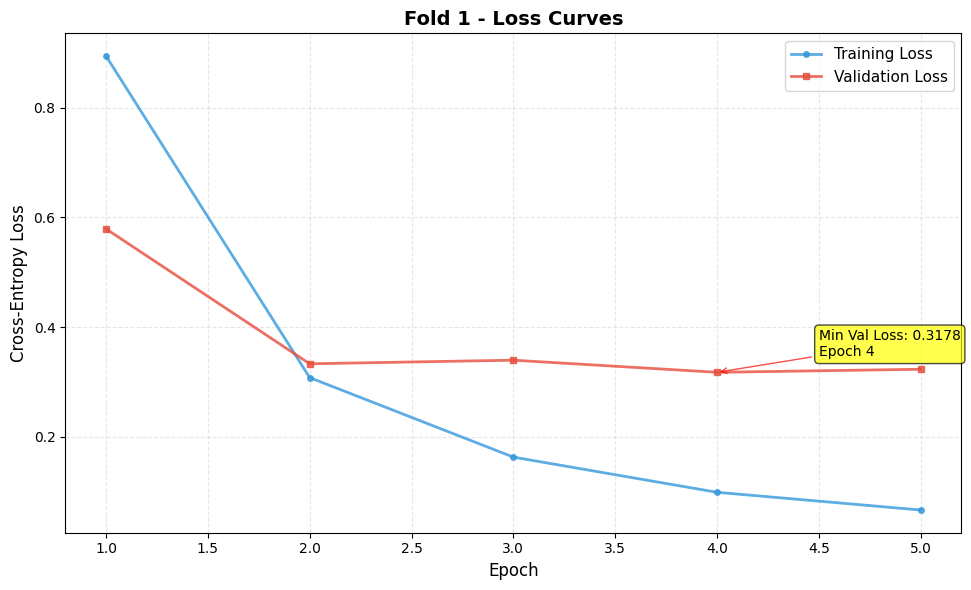

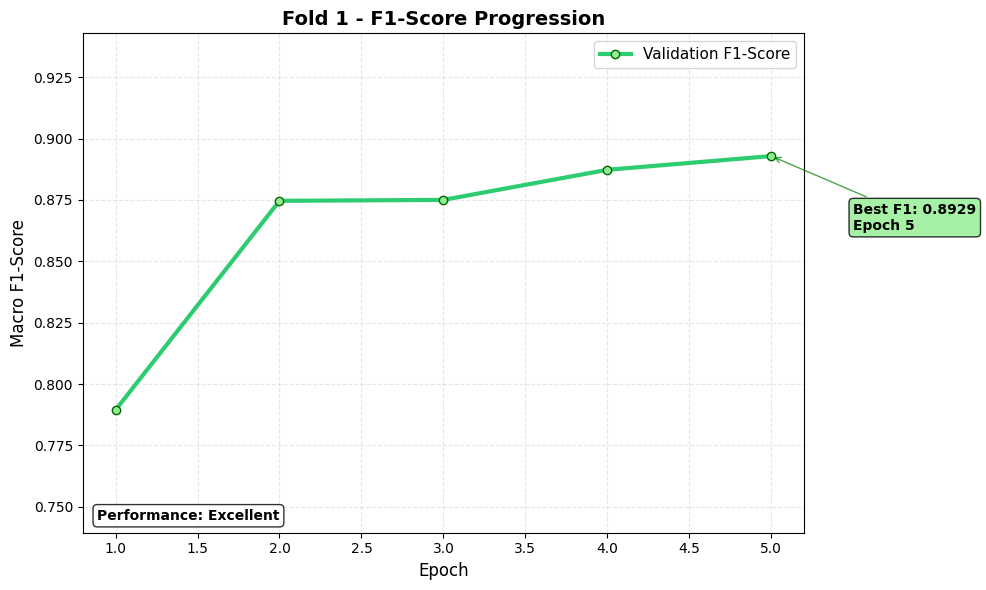

   🎵 Dataset initialized with 1212 samples
   📁 Audio folder: /kaggle/input/train
   🔧 Mel spectrogram: 16000Hz, 1024FFT, 128mel bins
   🎵 Dataset initialized with 303 samples
   📁 Audio folder: /kaggle/input/train
   🔧 Mel spectrogram: 16000Hz, 1024FFT, 128mel bins
🏗️ Building EfficientNet-B0 for 4 classes...
   📊 Original classifier input features: 1280
   🔄 Original output classes: 1000 (ImageNet)
   ✅ New classifier: 1280 → 4 classes
   🎯 Target classes: 4 Tajweed rules
   📈 Total parameters: 4,012,672
   🔧 Trainable parameters: 4,012,672
   💾 Estimated model size: 15.3 MB


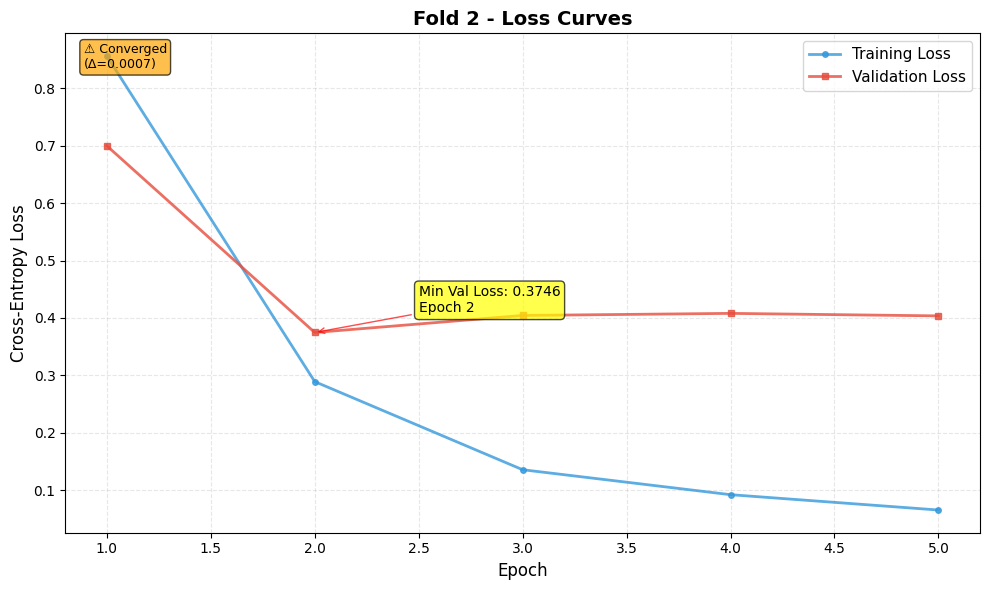

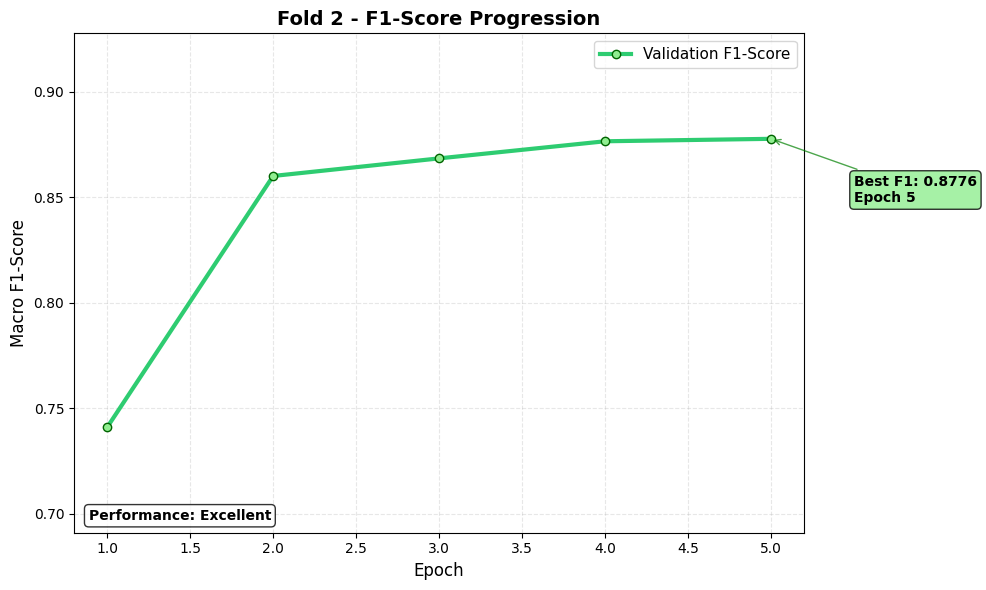

   🎵 Dataset initialized with 1212 samples
   📁 Audio folder: /kaggle/input/train
   🔧 Mel spectrogram: 16000Hz, 1024FFT, 128mel bins
   🎵 Dataset initialized with 303 samples
   📁 Audio folder: /kaggle/input/train
   🔧 Mel spectrogram: 16000Hz, 1024FFT, 128mel bins
🏗️ Building EfficientNet-B0 for 4 classes...
   📊 Original classifier input features: 1280
   🔄 Original output classes: 1000 (ImageNet)
   ✅ New classifier: 1280 → 4 classes
   🎯 Target classes: 4 Tajweed rules
   📈 Total parameters: 4,012,672
   🔧 Trainable parameters: 4,012,672
   💾 Estimated model size: 15.3 MB


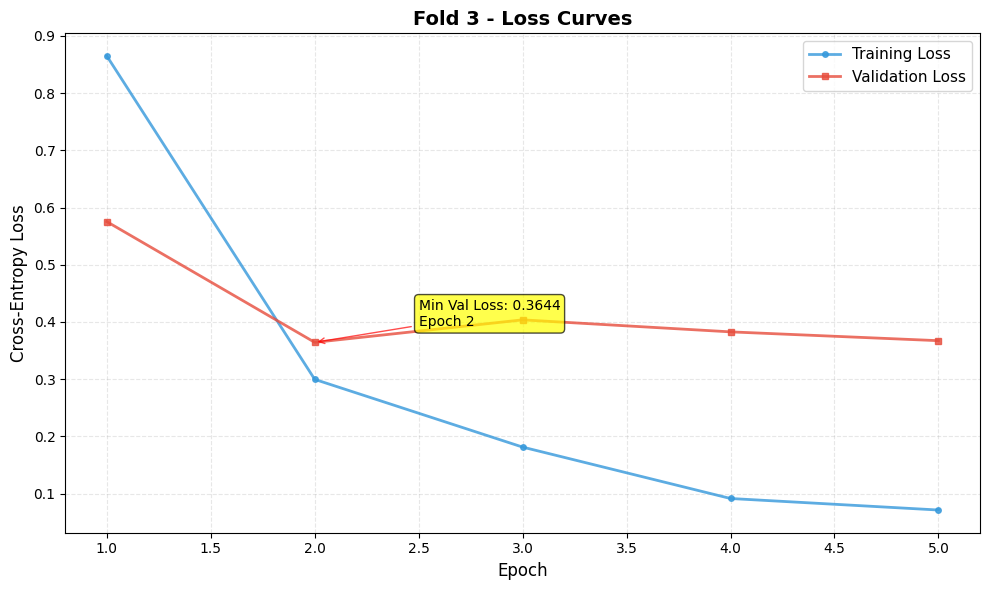

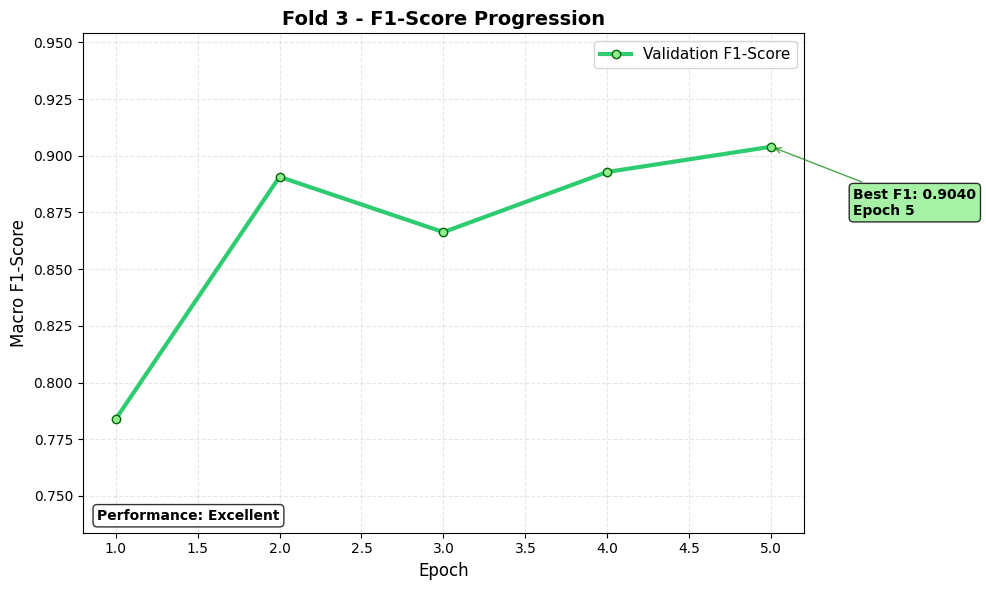

   🎵 Dataset initialized with 1212 samples
   📁 Audio folder: /kaggle/input/train
   🔧 Mel spectrogram: 16000Hz, 1024FFT, 128mel bins
   🎵 Dataset initialized with 303 samples
   📁 Audio folder: /kaggle/input/train
   🔧 Mel spectrogram: 16000Hz, 1024FFT, 128mel bins
🏗️ Building EfficientNet-B0 for 4 classes...
   📊 Original classifier input features: 1280
   🔄 Original output classes: 1000 (ImageNet)
   ✅ New classifier: 1280 → 4 classes
   🎯 Target classes: 4 Tajweed rules
   📈 Total parameters: 4,012,672
   🔧 Trainable parameters: 4,012,672
   💾 Estimated model size: 15.3 MB


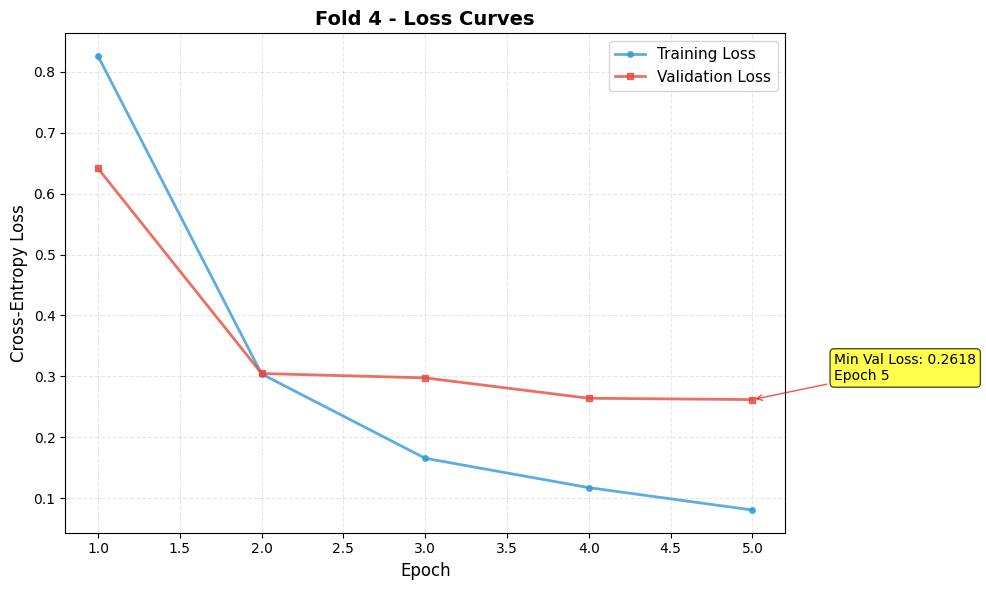

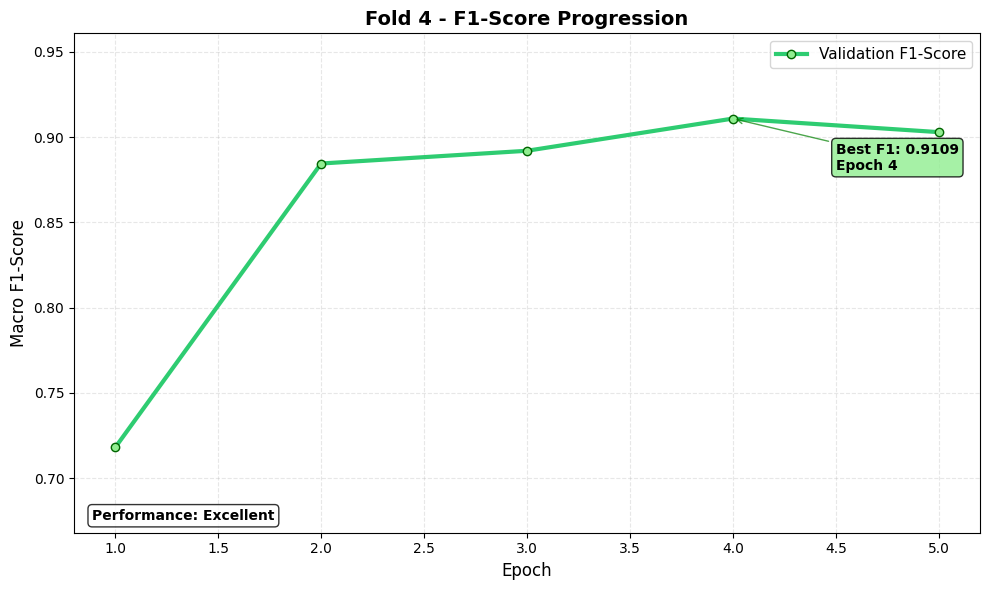

   🎵 Dataset initialized with 1212 samples
   📁 Audio folder: /kaggle/input/train
   🔧 Mel spectrogram: 16000Hz, 1024FFT, 128mel bins
   🎵 Dataset initialized with 303 samples
   📁 Audio folder: /kaggle/input/train
   🔧 Mel spectrogram: 16000Hz, 1024FFT, 128mel bins
🏗️ Building EfficientNet-B0 for 4 classes...
   📊 Original classifier input features: 1280
   🔄 Original output classes: 1000 (ImageNet)
   ✅ New classifier: 1280 → 4 classes
   🎯 Target classes: 4 Tajweed rules
   📈 Total parameters: 4,012,672
   🔧 Trainable parameters: 4,012,672
   💾 Estimated model size: 15.3 MB


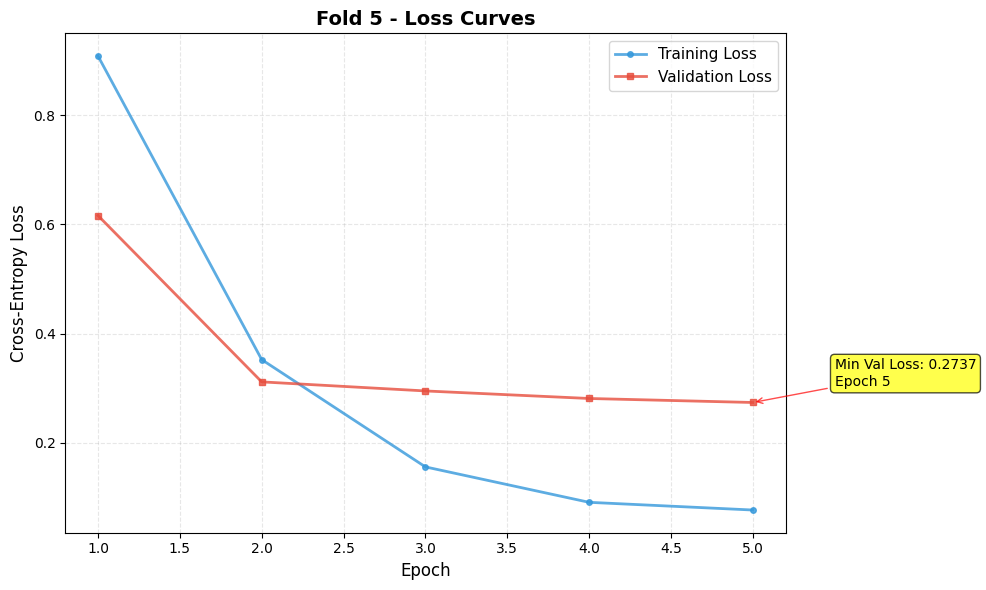

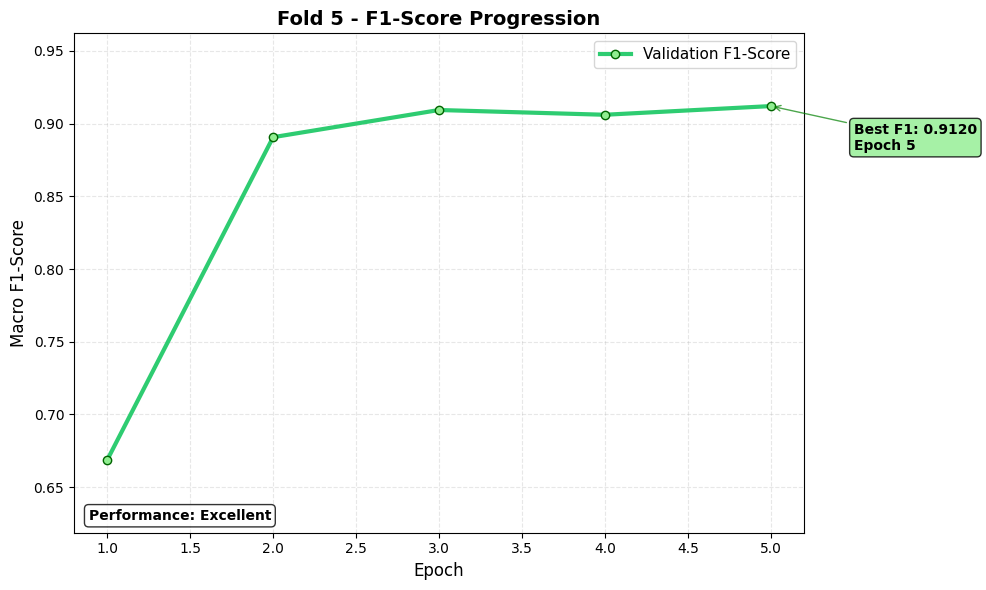

In [9]:
# Initialize tracking variables
f1_scores = []  # Store best F1 from each fold
fold_results = {}  # Detailed results for each fold
overall_start_time = time.time()

# Create stratified k-fold splitter
skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=SEED)

for fold, (tr_idx, va_idx) in enumerate(skf.split(train_df, y=train_df.y), 1):
    fold_start_time = time.time()

    # Create data splits with detailed logging
    train_split = train_df.iloc[tr_idx]
    val_split = train_df.iloc[va_idx]


    # Check class distribution in splits
    train_dist = train_split['label_name'].value_counts()
    val_dist = val_split['label_name'].value_counts()


    # Create data loaders with appropriate settings
    tr_dl = DataLoader(
        TajweedSpecDataset(train_split, TRAIN_DIR),
        batch_size=BATCH,
        shuffle=True,      # Shuffle training data for better learning
        num_workers=2,     # Parallel data loading
        pin_memory=True,   # Faster GPU transfer
        drop_last=True     # Drop incomplete batches for consistent training
    )

    va_dl = DataLoader(
        TajweedSpecDataset(val_split, TRAIN_DIR),
        batch_size=BATCH,
        shuffle=False,     # No shuffle needed for validation
        num_workers=2,
        pin_memory=True
    )

    # Initialize model and training components
    model = build_model(n_classes=4).to(DEVICE)

    # AdamW optimizer with weight decay for regularization
    opt = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)

    # Cosine annealing learning rate scheduler
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=EPOCHS)

    # Loss function for multi-class classification
    crit = nn.CrossEntropyLoss()

    # F1 score metric for evaluation (macro average handles class imbalance)
    f1m = F1Score(task="multiclass", num_classes=4, average="macro").to(DEVICE)

    # Training tracking variables
    best_f1 = 0
    train_losses, val_losses, val_f1s = [], [], []
    epochs_without_improvement = 0


    # Training loop for this fold
    for ep in range(1, EPOCHS + 1):
        epoch_start_time = time.time()

        # ============ TRAINING PHASE ============
        model.train()  # Set model to training mode
        running_loss = 0.0
        samples_processed = 0

        # Progress bar for training batches
        train_pbar = tqdm(tr_dl, desc=f'Fold{fold} Ep{ep:02d} Train',
                         leave=False, ncols=100)

        for batch_idx, (xb, yb) in enumerate(train_pbar):
            # Move data to device
            xb, yb = xb.to(DEVICE, non_blocking=True), yb.to(DEVICE, non_blocking=True)

            # Forward pass
            opt.zero_grad()
            logits = model(xb)
            loss = crit(logits, yb)

            # Backward pass
            loss.backward()
            opt.step()

            # Track metrics
            batch_loss = loss.item()
            batch_size = xb.size(0)
            running_loss += batch_loss * batch_size
            samples_processed += batch_size

            # Update progress bar
            train_pbar.set_postfix({
                'loss': f'{batch_loss:.4f}',
                'avg_loss': f'{running_loss/samples_processed:.4f}'
            })

        # Calculate average training loss
        epoch_train_loss = running_loss / samples_processed
        train_losses.append(epoch_train_loss)

        # ============ VALIDATION PHASE ============
        model.eval()  # Set model to evaluation mode
        f1m.reset()   # Reset F1 metric
        val_loss_acc = 0.0
        val_samples = 0

        # Progress bar for validation batches
        val_pbar = tqdm(va_dl, desc=f'Fold{fold} Ep{ep:02d} Val',
                       leave=False, ncols=100)

        with torch.no_grad():  # Disable gradient computation for efficiency
            for batch_idx, (xb, yb) in enumerate(val_pbar):
                xb, yb = xb.to(DEVICE, non_blocking=True), yb.to(DEVICE, non_blocking=True)

                # Forward pass
                logits = model(xb)
                val_loss = crit(logits, yb)

                # Accumulate validation loss
                batch_size = xb.size(0)
                val_loss_acc += val_loss.item() * batch_size
                val_samples += batch_size

                # Update F1 metric
                f1m.update(logits.softmax(1), yb)

                # Update progress bar
                val_pbar.set_postfix({
                    'val_loss': f'{val_loss.item():.4f}',
                    'avg_val_loss': f'{val_loss_acc/val_samples:.4f}'
                })

        # Calculate validation metrics
        epoch_val_loss = val_loss_acc / val_samples
        val_losses.append(epoch_val_loss)

        val_f1 = f1m.compute().item()
        val_f1s.append(val_f1)

        # Update learning rate
        sched.step()
        current_lr = opt.param_groups[0]['lr']

        # Calculate epoch timing
        epoch_time = time.time() - epoch_start_time

        # Model checkpointing - save if this is the best validation F1
        if val_f1 > best_f1:
            best_f1 = val_f1
            torch.save(model.state_dict(), f"effb0_fold{fold}.pt")
            epochs_without_improvement = 0
            improvement_indicator = "🌟 NEW BEST!"
        else:
            epochs_without_improvement += 1
            improvement_indicator = f"({epochs_without_improvement} epochs since improvement)"


    # End of fold - generate visualizations and summary
    fold_time = time.time() - fold_start_time



    # Store fold results
    fold_results[fold] = {
        'best_f1': best_f1,
        'final_train_loss': train_losses[-1],
        'final_val_loss': val_losses[-1],
        'training_time': fold_time,
        'train_losses': train_losses.copy(),
        'val_losses': val_losses.copy(),
        'val_f1s': val_f1s.copy()
    }

    # Generate and display learning curves for this fold
    plot_loss(train_losses, val_losses, fold)
    plot_score(val_f1s, fold)

    # Add best F1 to overall results
    f1_scores.append(best_f1)


    # Memory cleanup
    del model, opt, sched, tr_dl, va_dl
    torch.cuda.empty_cache() if torch.cuda.is_available() else None
    gc.collect()

# Contributed by: Mohamed Eltayeb (He did everything) - Edited by: Ali Habibullah (I added comments and markdowns 😶‍🌫️)
